## LSL (3) vs NSL (0)

### Import Libraries

In [1]:
from util_comp import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import time
import warnings

import xgboost


from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression

# Makes sure we see all columns
pd.set_option('display.max_columns', None)

# ignore warnings
warnings.filterwarnings('ignore')

### Load the data

In [2]:
df = pd.DataFrame(main(retained=True))
print(df.shape)
df.head()

Only retained columns are used
Shape of data: (44535, 72)
Elapsed time to compute age categorisation: 0 minutes and 0 seconds
Elapsed time to compute load column names: 0 minutes and 0 seconds
Elapsed time to compute clean data: 0 minutes and 0 seconds
Elapsed time to compute categorisation of outcome column: 0 minutes and 3 seconds
Elapsed time to compute change values in catagorical columns: 1 minutes and 8 seconds
Elapsed time to compute Full process: 1 minutes and 11 seconds
(37681, 67)


,Gender,Age,Work type,sector,size of business,No of 3 to 6 years old children,No of 7 to 12 years old children,No of 13 to 17 years old children,No of 18 years and over children,dependents,Full Time/Part Time,shift work with alternating hours,Place of work,standing or in an awkward posture,carry or move heavy loads,perform repetitive gestures,work on screen,cold/ hot env,work in noisy env,breathe toxic products or dust,handle toxic or dangerous products,risk of serious fall,machinery with exposure to injury,learn new things,work quickly or very intensely,long periods of concentration,physically tiring,mentally tiring,satisfaction with work,make decisions,difficulty managing priorities,recognized by my hierarchy,develop professional skills,good understanding where I work,well-suited workstation,seek to improve the way I work,well-being of its employees,Security is a priority,count on supervisor,recommend the company,decreased alertness,hurtful or aggressive remarks,insulted or attacked by the public or customers,clarity of your role in the company,access to professional training,tools or workstation,prospects for development,mastery of position,difficulty reconciling your work with your other personal commitments,transportation,personal concerns,can talk to loved ones,state of health in general,long-term illness,Disabilities,Headaches,"neck, shoulder, arm pain",back pain,"leg, foot, knee pain",other parts of the body pain,midday meal,drinks (At least once a week),smoker,"sleeping pills, anxiolytics or anti-depressants",Sleep disorders,lack of tone,outcome
0,A man,30 - 39,AM Technicians,Wholesale trade (all businesses in 206),250 - 999,1.0,2.0,0.0,0.0,No,Full time,No,In a shared office (3 to 5 people),Never,Never,Rarely,Most of the time,Most of the time,Never,No,No,No,No,Rather,Rather,Rather,Rather not,Rather,Rather,Rather,Rather not,Rather,Rather,Rather,Rather,Rather,Rather,Rather,Rather,NaN,Sometimes,Never,Never,NaN,NaN,NaN,NaN,NaN,"Yes, rather",Less than 1 hour per day,Rather not,NaN,Good,No,No,Never,Never,Never,Often,Never,When returning home,Alcoholic beverages,Yes,Never,sometimes,sometimes,SSL
1,A man,18 - 30,Frames,Wholesale trade (all businesses in 206),50 - 249,0.0,0.0,0.0,0.0,No,Full time,No,In a shared office (3 to 5 people),Rarely,Never,Rarely,Most of the time,Never,Most of the time,No,No,No,Yes,Rather,Rather,Rather,Rather not,Completely,Rather,Rather,Rather not,Rather,Rather not,Completely,Rather,Rather,Completely,Completely,Rather,NaN,Sometimes,Never,Very Often,NaN,NaN,NaN,NaN,NaN,"No, rather not",Less than 1 hour per day,Not at all,NaN,Good,No,No,Sometimes,Sometimes,Sometimes,Permanently,Permanently,By bringing your meal from home,Alcoholic beverages,No,Never,Never,Never,VSSL
2,A woman,45 - 49,Employees,Wholesale trade (all businesses in 206),0 - 10,0.0,0.0,1.0,1.0,No,Full time,No,At home teleworking,Rarely,Rarely,Rarely,Never,Never,Never,No,No,No,No,Completely,Rather not,Rather,Rather not,Rather not,Rather,Completely,Rather not,Rather not,Rather,Completely,Rather,Completely,Rather,Completely,Rather not,NaN,Sometimes,Never,Never,NaN,NaN,NaN,NaN,NaN,No not at all,Less than 1 hour per day,Not at all,NaN,Good,Yes,No,Sometimes,Sometimes,Sometimes,Never,Sometimes,When returning home,NaN,No,Never,often,sometimes,LSL
3,A man,30 - 39,Frames,Wholesale trade (all businesses in 206),50 - 249,0.0,0.0,0.0,0.0,No,Full time,No,In a shared office (3 to 5 people),NaN,Most of the time,Most of the time,Most of the time,Rarely,Rarely,No,No,No,No,Rather not,Completely,Completely,Rather,Completely,Rather,Completely,Not at all,Not at all,Rather,Rather,Rather,Rather,Not at all,Rather,Not at all,NaN,Very Often,Very Often,Very Often,NaN,NaN,NaN,NaN,NaN,"Yes, rather",Between 1 hour and 2 hours per day,Rather not,NaN,Good,Yes,No,Often,Often,Often,Often,Often,While eating a sandwich,NaN,No,Never,sometimes,often,NoSL
4,A man,56 - 70,Workers,Industry,Oct-49,0.0,0.0,0.0,0.0,No,Full time,Yes,"In a workshop, a technical room",Most of the time,Most

In [3]:
df["outcome"].value_counts()

NoSL    24060
LSL      5662
VSSL     4698
SSL      3261
Name: outcome, dtype: int64

In [4]:
from pandas.api.types import CategoricalDtype
cat_dtype = CategoricalDtype(
    categories=["NoSL", "VSSL", "SSL", "LSL"], ordered=True)

for cols in df.columns:
    if cols not in not_cat:
        if cols == "outcome":
            df[cols] = df[cols].astype(cat_dtype)
        df[cols] = df[cols].astype("category").cat.codes

In [5]:
df["outcome"].value_counts()

0    24060
3     5662
1     4698
2     3261
Name: outcome, dtype: int64

#### split data to train and test sets

In [6]:
data = df

# Split the data for training and evaluation
# X: features with the outcome column removed, where outcome is 2 or 3
# y: outcome column

# get the rows withs outcome 2 or 3
X = data[(data['outcome'] == 2) | (data['outcome'] == 3)].drop('outcome', axis=1, inplace=False)
X.columns = [str(i) for i in X.columns]
y = data[(data['outcome'] == 2) | (data['outcome'] == 3)]['outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


#### Train the Random Forest model

In [7]:
# Fit RF (blackbox) model
t1 = time.time()
sl = RandomForestClassifier(class_weight='balanced')
sl.fit(X_train, y_train)
t2 = time.time()
print(time_e(t1, t2, "fitting RF model"))

Elapsed time to compute fitting RF model: 0 minutes and 1 seconds


In [8]:
y_pred = sl.predict(X_test)
y_pred_proba = sl.predict_proba(X_test)

In [9]:
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy of test: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy of train: {accuracy_score(y_train, sl.predict(X_train))}")

# ROAUC

print(f"ROAUC: {roc_auc_score(y_test, y_pred_proba[:,1])}")
print(f"Confusin matrix: \n{confusion_matrix(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

F1 Score: 0.5609171965674583
Accuracy of test: 0.6666666666666666
Accuracy of train: 1.0
ROAUC: 0.6647566298965347
Confusin matrix: 
[[ 157  490]
 [ 105 1033]]
              precision    recall  f1-score   support

           2       0.60      0.24      0.35       647
           3       0.68      0.91      0.78      1138

    accuracy                           0.67      1785
   macro avg       0.64      0.58      0.56      1785
weighted avg       0.65      0.67      0.62      1785



## Explanantion using SHAP

In [10]:
explainer = shap.TreeExplainer(sl)

# Calculate shapley values for test data
start_index = 0
end_index = 10

# time to run 10 samples
s_time = time.time()
shap_values = explainer.shap_values(X_test[start_index:end_index]) # 0 - 9
e_time = time.time()
time_e(s_time, e_time, f"Shapley values for test data[{start_index}:{end_index}]")
X_test[start_index:end_index]

,Gender,Age,Work type,sector,size of business,No of 3 to 6 years old children,No of 7 to 12 years old children,No of 13 to 17 years old children,No of 18 years and over children,dependents,Full Time/Part Time,shift work with alternating hours,Place of work,standing or in an awkward posture,carry or move heavy loads,perform repetitive gestures,work on screen,cold/ hot env,work in noisy env,breathe toxic products or dust,handle toxic or dangerous products,risk of serious fall,machinery with exposure to injury,learn new things,work quickly or very intensely,long periods of concentration,physically tiring,mentally tiring,satisfaction with work,make decisions,difficulty managing priorities,recognized by my hierarchy,develop professional skills,good understanding where I work,well-suited workstation,seek to improve the way I work,well-being of its employees,Security is a priority,count on supervisor,recommend the company,decreased alertness,hurtful or aggressive remarks,insulted or attacked by the public or customers,clarity of your role in the company,access to professional training,tools or workstation,prospects for development,mastery of position,difficulty reconciling your work with your other personal commitments,transportation,personal concerns,can talk to loved ones,state of health in general,long-term illness,Disabilities,Headaches,"neck, shoulder, arm pain",back pain,"leg, foot, knee pain",other parts of the body pain,midday meal,drinks (At least once a week),smoker,"sleeping pills, anxiolytics or anti-depressants",Sleep disorders,lack of tone
23118,1,0,1,7,1,0.0,0.0,0.0,0.0,2,0,1,8,2,2,2,2,2,0,1,1,0,1,2,3,2,2,2,0,2,2,2,2,2,2,2,2,2,2,3,1,1,1,0,1,0,0,0,3,0,3,2,2,0,0,3,3,1,1,1,0,1,1,2,3,3
8320,0,1,3,5,3,0.0,1.0,1.0,0.0,1,0,0,6,0,2,0,1,0,2,1,0,1,1,0,0,2,0,3,2,2,1,3,2,2,2,2,3,3,2,-1,2,2,0,1,1,0,1,-1,0,2,1,2,2,0,0,3,3,1,0,3,3,1,0,2,3,0
895,1,3,2,3,1,0.0,0.0,0.0,2.0,0,0,0,7,1,1,1,0,2,3,0,0,0,0,2,3,2,3,2,2,0,3,2,2,0,0,0,2,2,2,-1,2,0,0,-1,-1,-1,-1,-1,1,2,2,-1,2,0,0,3,0,3,3,1,2,-1,0,2,0,3
30852,1,3,3,7,2,0.0,0.0,1.0,2.0,0,0,0,5,3,0,0,1,0,3,0,0,1,1,0,3,0,0,2,0,0,2,3,0,0,3,0,2,0,0,2,1,0,0,0,0,0,1,0,1,2,3,0,2,0,0,3,3,1,3,3,4,-1,1,2,3,3
33786,0,4,2,8,0,0.0,1.0,0.0,0.0,0,0,0,0,2,2,2,2,-1,2,1,1,0,1,0,0,0,2,2,2,0,3,2,0,2,2,0,2,0,2,2,0,2,0,0,1,0,0,0,3,0,3,0,0,1,0,3,3,1,1,-1,2,2,0,2,1,1
18861,1,1,2,6,1,0.0,0.0,0.0,0.0,0,0,0,8,1,1,0,0,1,2,0,0,0,0,2,0,0,3,0,3,2,3,3,2,3,3,2,1,2,1,1,2,0,0,1,1,0,1,0,3,1,3,2,1,1,0,3,3,3,0,3,2,-1,0,2,3,3
10374,1,3,3,2,1,0.0,0.0,0.0,1.0,0,0,0,8,0,0,0,3,1,2,1,1,1,0,2,2,2,0,0,2,1,2,3,3,2,3,2,3,3,3,2,2,0,2,0,1,0,1,0,1,2,2,0,0,0,0,3,3,3,0,0,0,1,0,2,3,3
4653,1,3,2,0,2,0.0,0.0,0.0,4.0,0,0,0,3,0,1,3,0,3,3,0,0,0,0,0,3,2,1,3,0,2,2,2,2,0,0,2,2,2,2,-1,2,0,0,-1,-1,-1,-1,-1,1,0,1,-1,1,1,0,1,2,2,2,1,3,-1,0,2,3,1
9604,0,2,3,3,2,1.0,2.0,0.0,0.0,0,0,1,3,2,2,2,0,0,0,1,1,1,1,2,3,2,2,2,0,2,3,0,2,2,2,0,2,0,0,-1,2,2,2,0,1,0,0,-1,3,2,3,0,2,0,0,3,3,1,3,3,3,0,0,2,3,3
7167,1,0,1,3,1,0.0,0.0,0.0,0.0,0,0,0,3,1,1,3,0,1,2,0,0,0,0,2,3,3,1,2,0,3,3,3,2,0,2,2,3,2,2,-1,2,2,2,1,1,0,1,-1,1,2,3,0,2,1,0,3,3,1,3,3,0,1,0,2,3,3


In [11]:
y_test[start_index:end_index]

23118    2
8320     3
895      3
30852    3
33786    3
18861    2
10374    3
4653     3
9604     2
7167     2
Name: outcome, dtype: int8

### SHAP Values

In [12]:
print(shap_values[0].shape)
shap_values

(66, 2)


array([[[-0.00240676,  0.00240676],
        [-0.00111588,  0.00111588],
        [ 0.0008047 , -0.0008047 ],
        ...,
        [ 0.00339236, -0.00339236],
        [-0.00258821,  0.00258821],
        [ 0.00462853, -0.00462853]],

       [[ 0.00542201, -0.00542201],
        [ 0.01408291, -0.01408291],
        [-0.00465871,  0.00465871],
        ...,
        [ 0.00218744, -0.00218744],
        [-0.00253528,  0.00253528],
        [-0.01565579,  0.01565579]],

       [[-0.01238763,  0.01238763],
        [-0.00777916,  0.00777916],
        [ 0.01381978, -0.01381978],
        ...,
        [ 0.00520051, -0.00520051],
        [ 0.00529021, -0.00529021],
        [ 0.00289087, -0.00289087]],

       ...,

       [[-0.00517864,  0.00517864],
        [-0.02060246,  0.02060246],
        [ 0.00596544, -0.00596544],
        ...,
        [ 0.00486869, -0.00486869],
        [-0.00092188,  0.00092188],
        [-0.00546854,  0.00546854]],

       [[ 0.00350121, -0.00350121],
        [-0.00370334,  0.00

In [13]:
shap.initjs()
# Force plot
prediction = sl.predict(X_test[start_index:end_index])[0]
print(f"The sl predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                shap_values[...,1],
                X_test[start_index:end_index])  # for values

The sl predicted: 3


### Summary of Variables that affected the prediction using SHAP

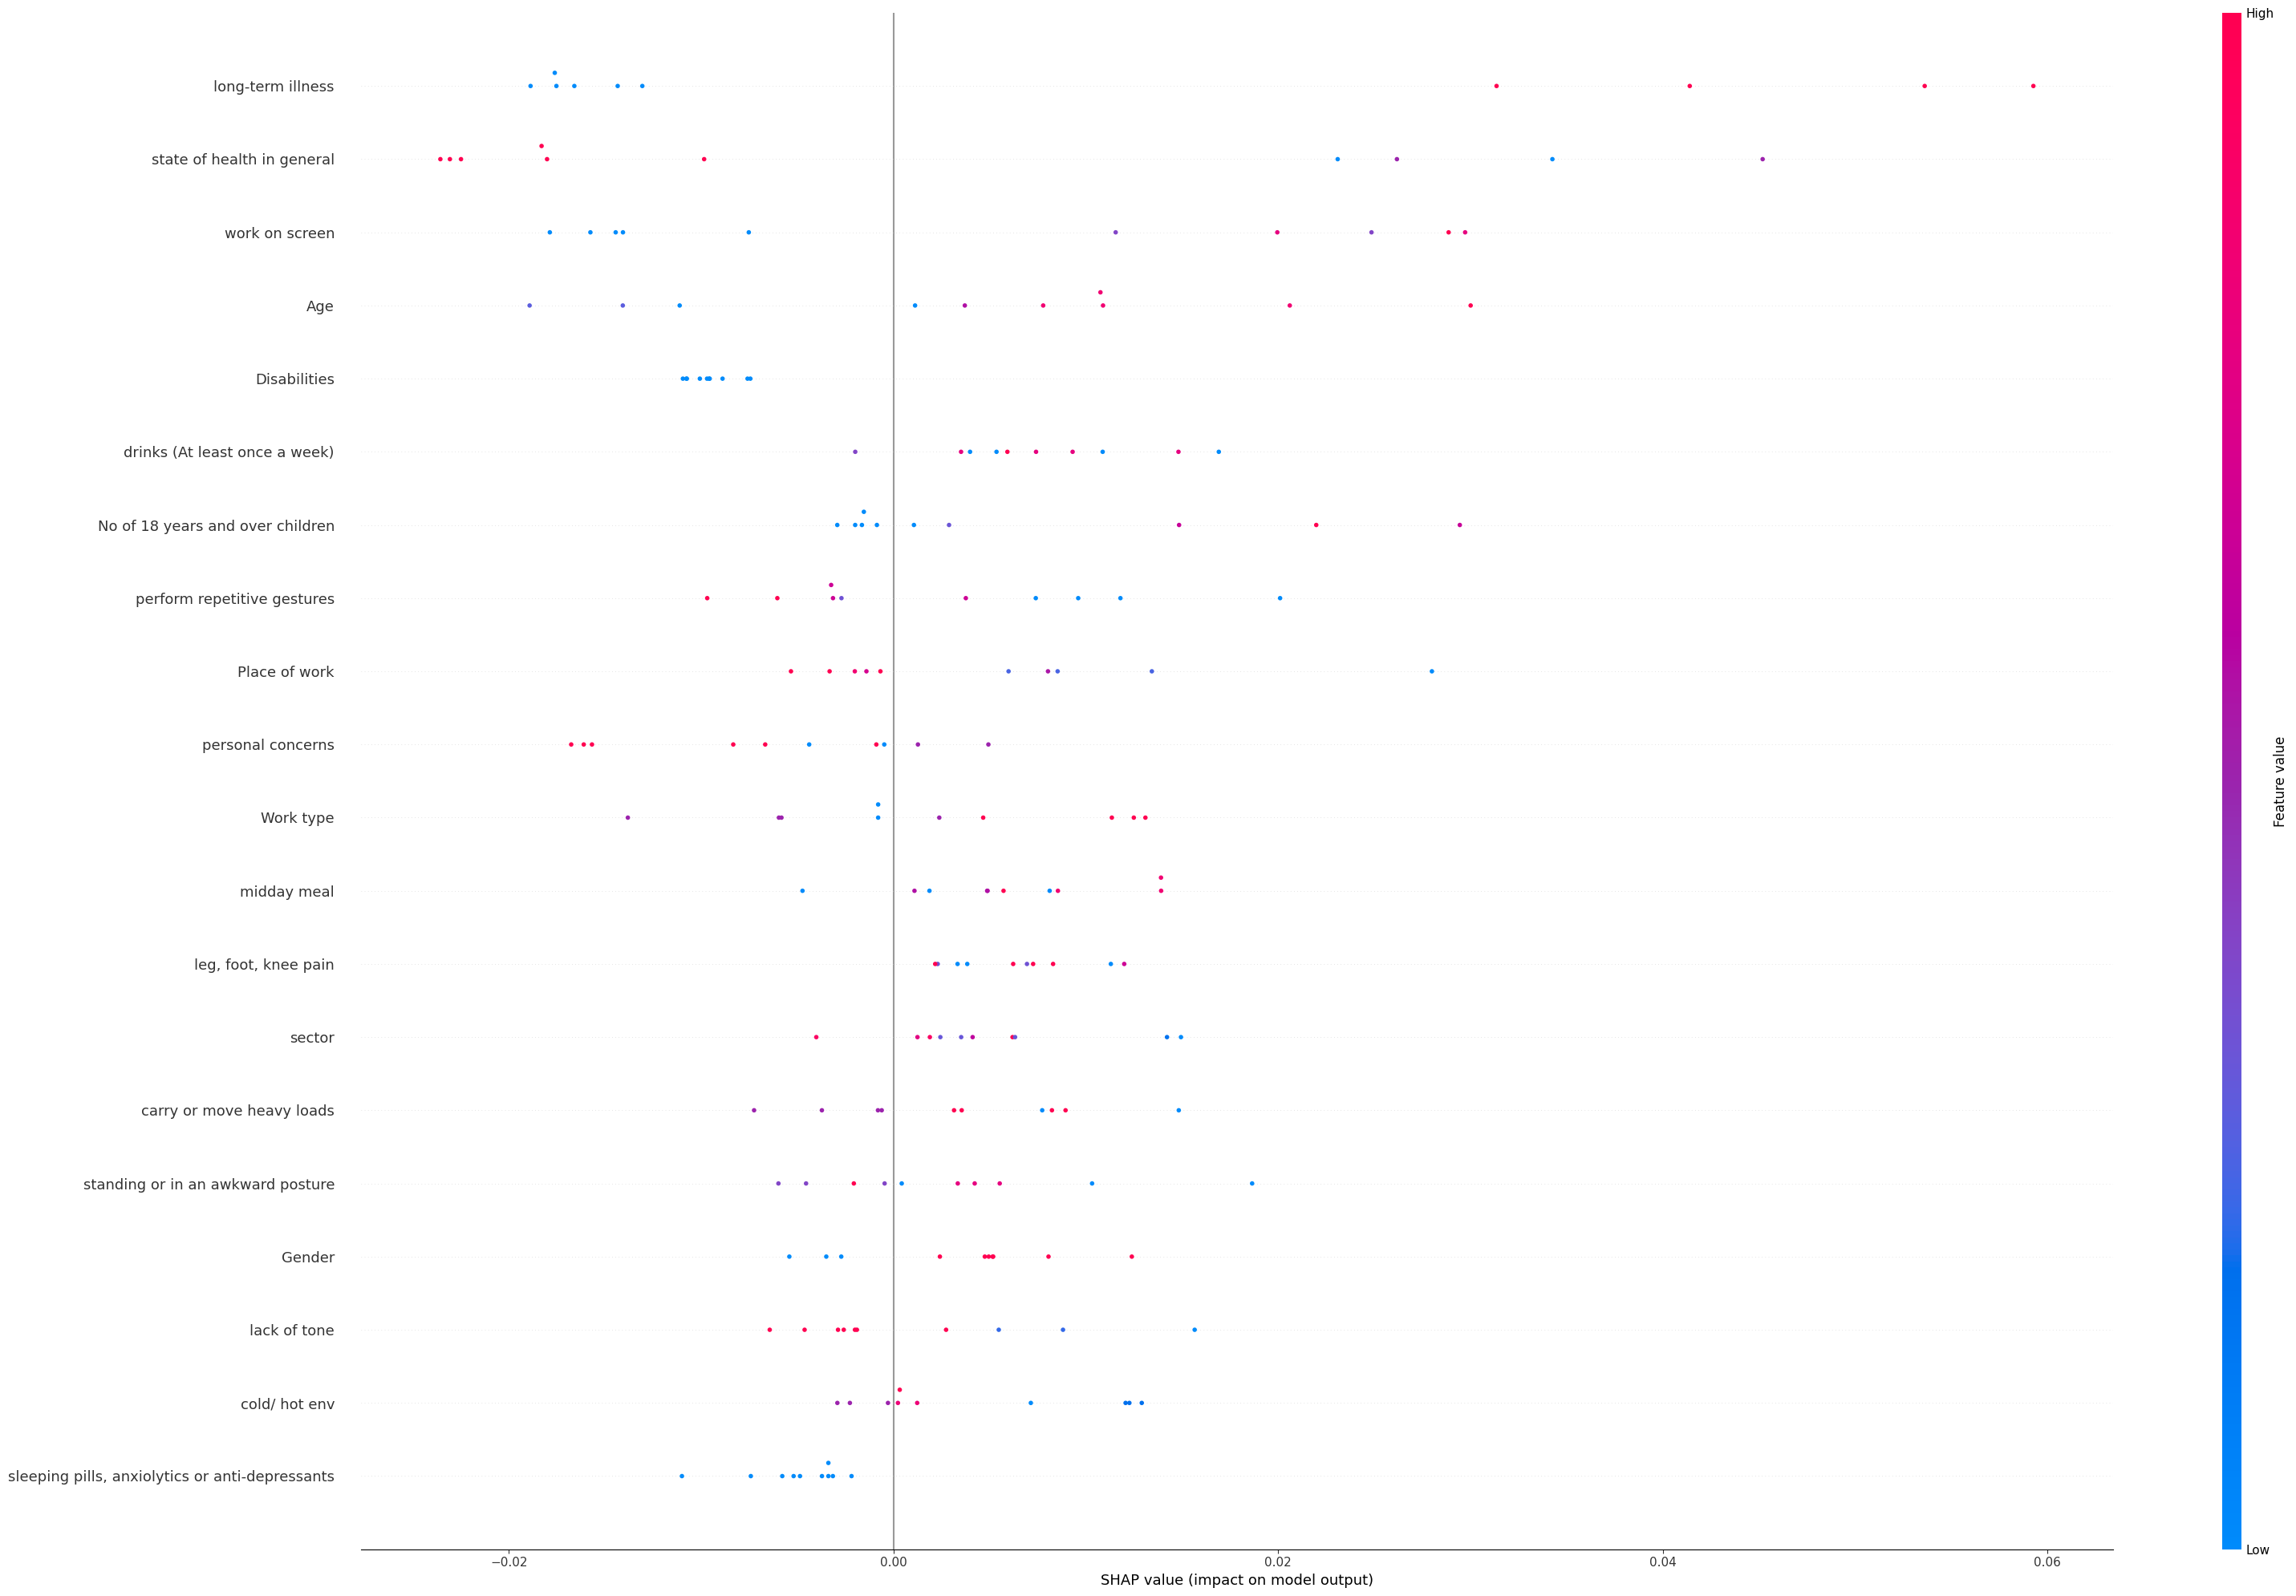

In [14]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_size=(32,20), show=False)
plt.savefig('outputs/02_23_shap/summary_plot_for_10_samples.png', bbox_inches='tight')
plt.show()

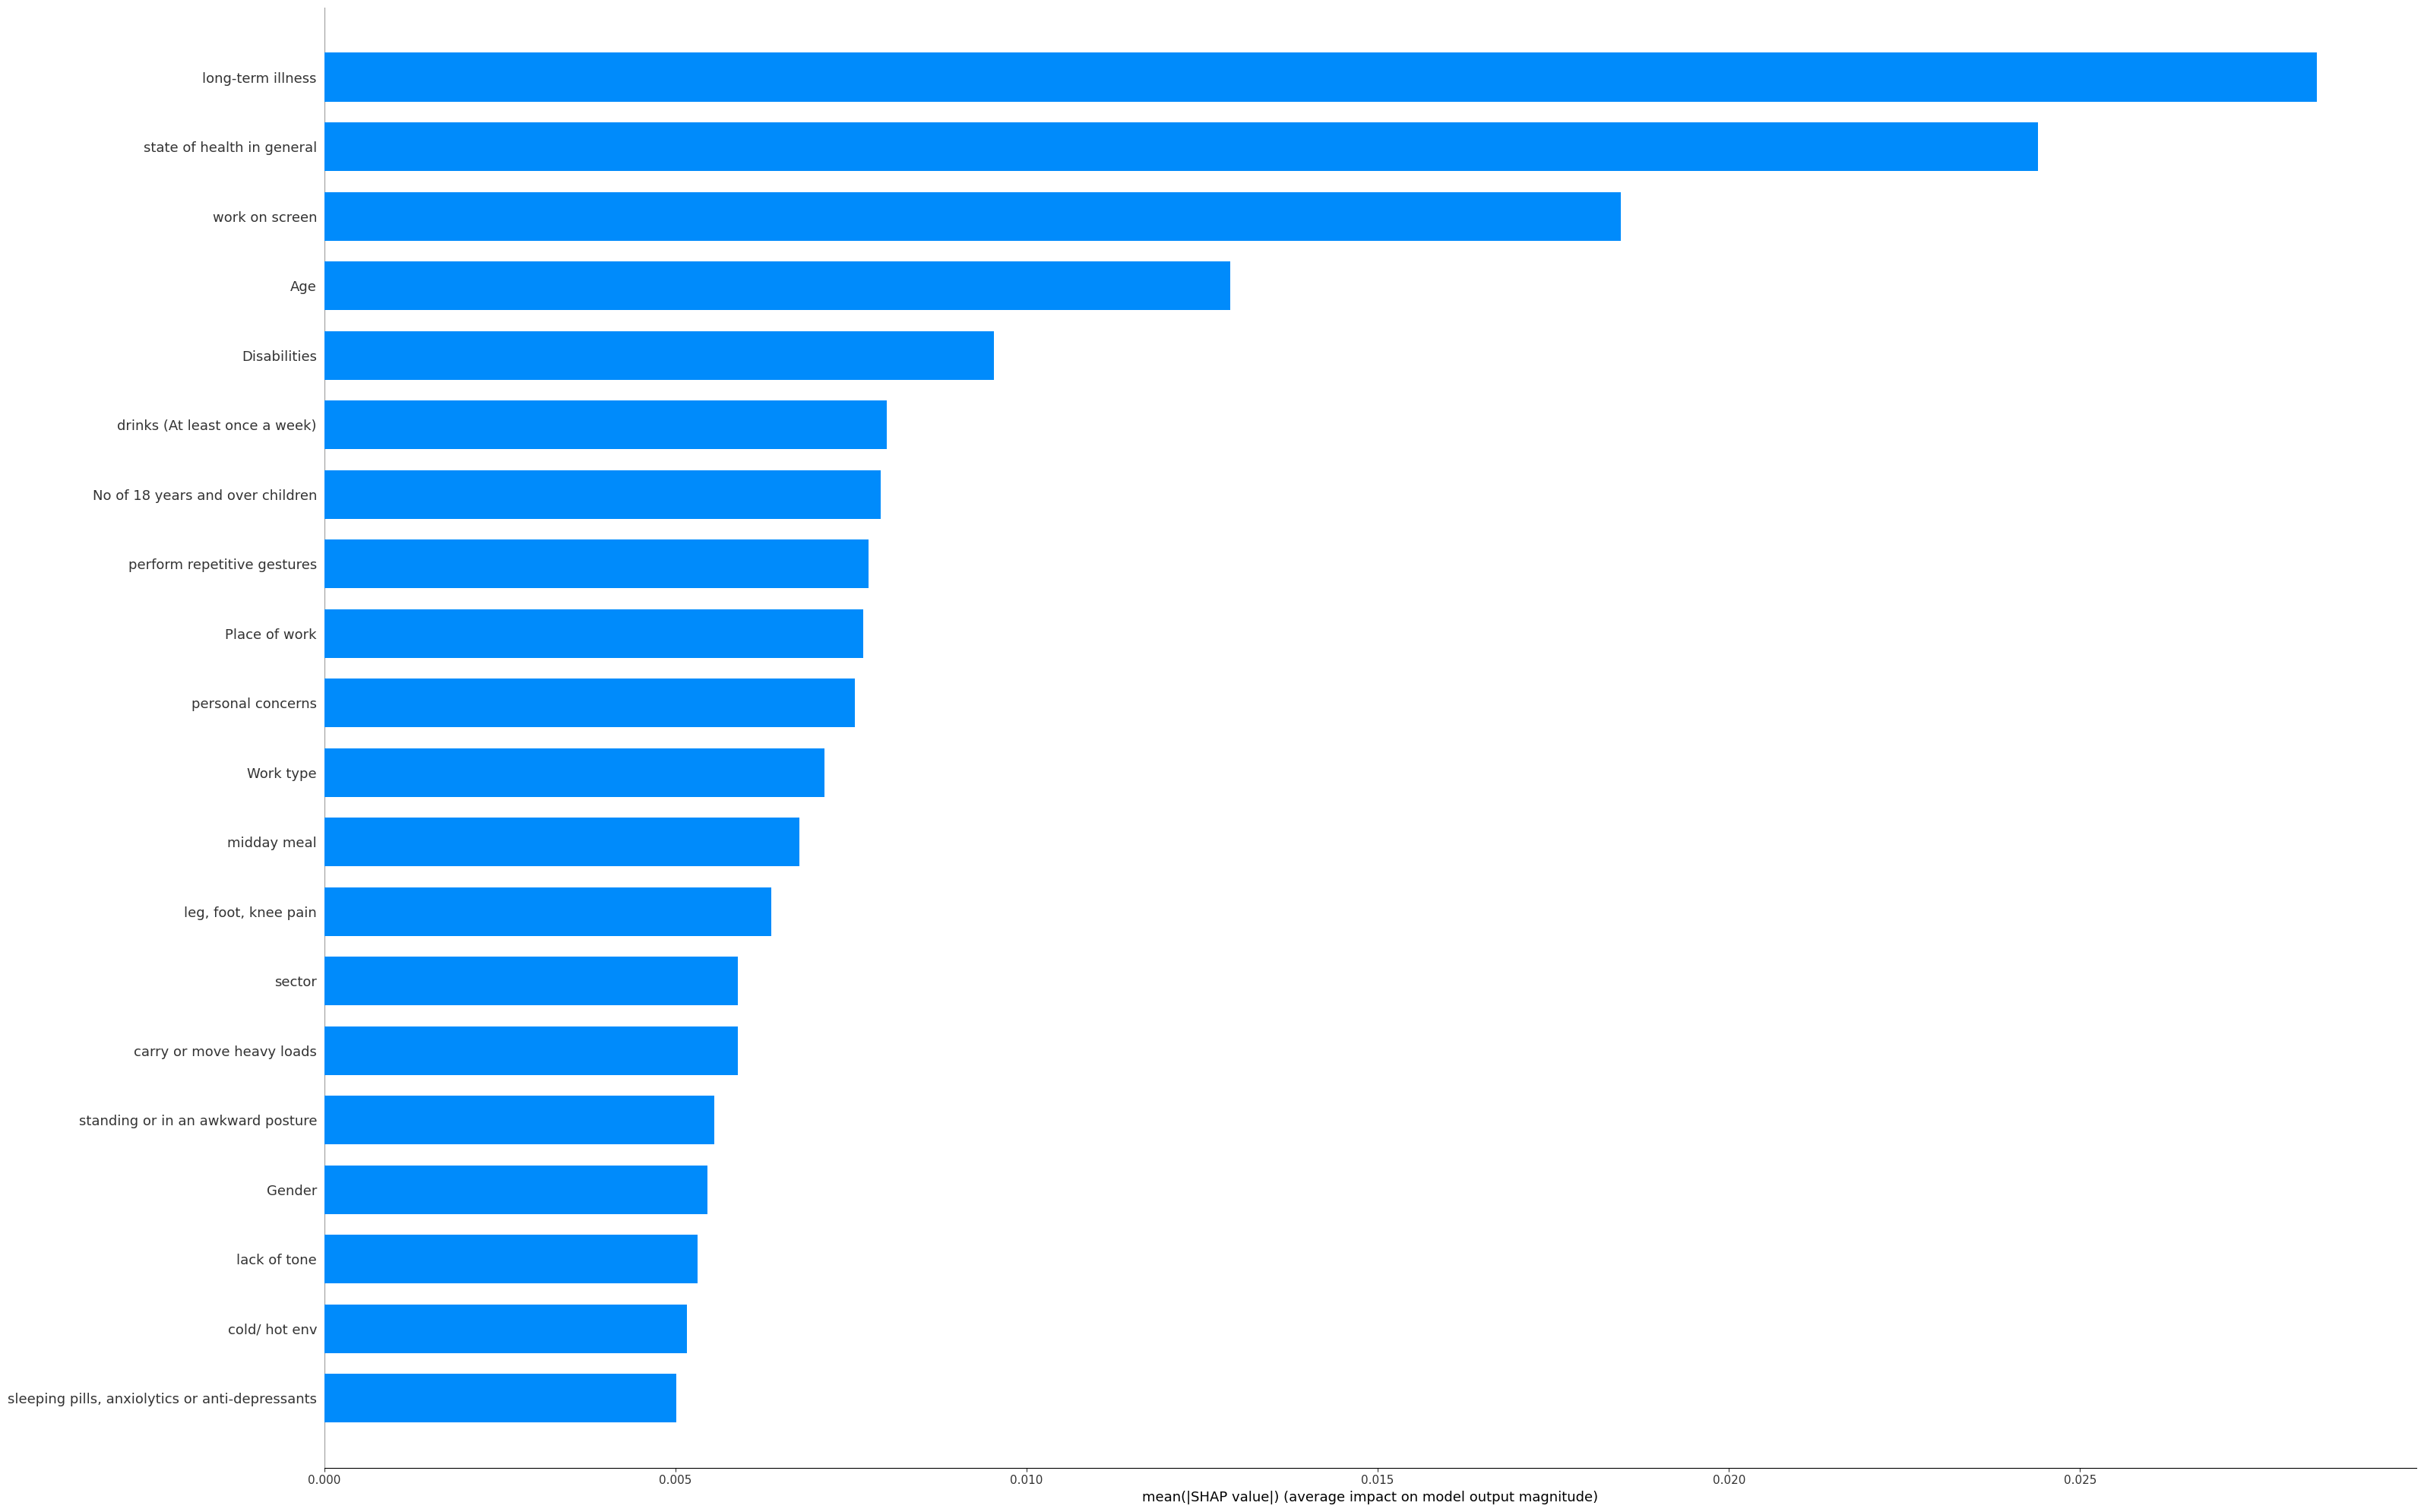

In [15]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_23_shap/summary_plot_bar_for_10_samples.png', bbox_inches='tight')
plt.show()

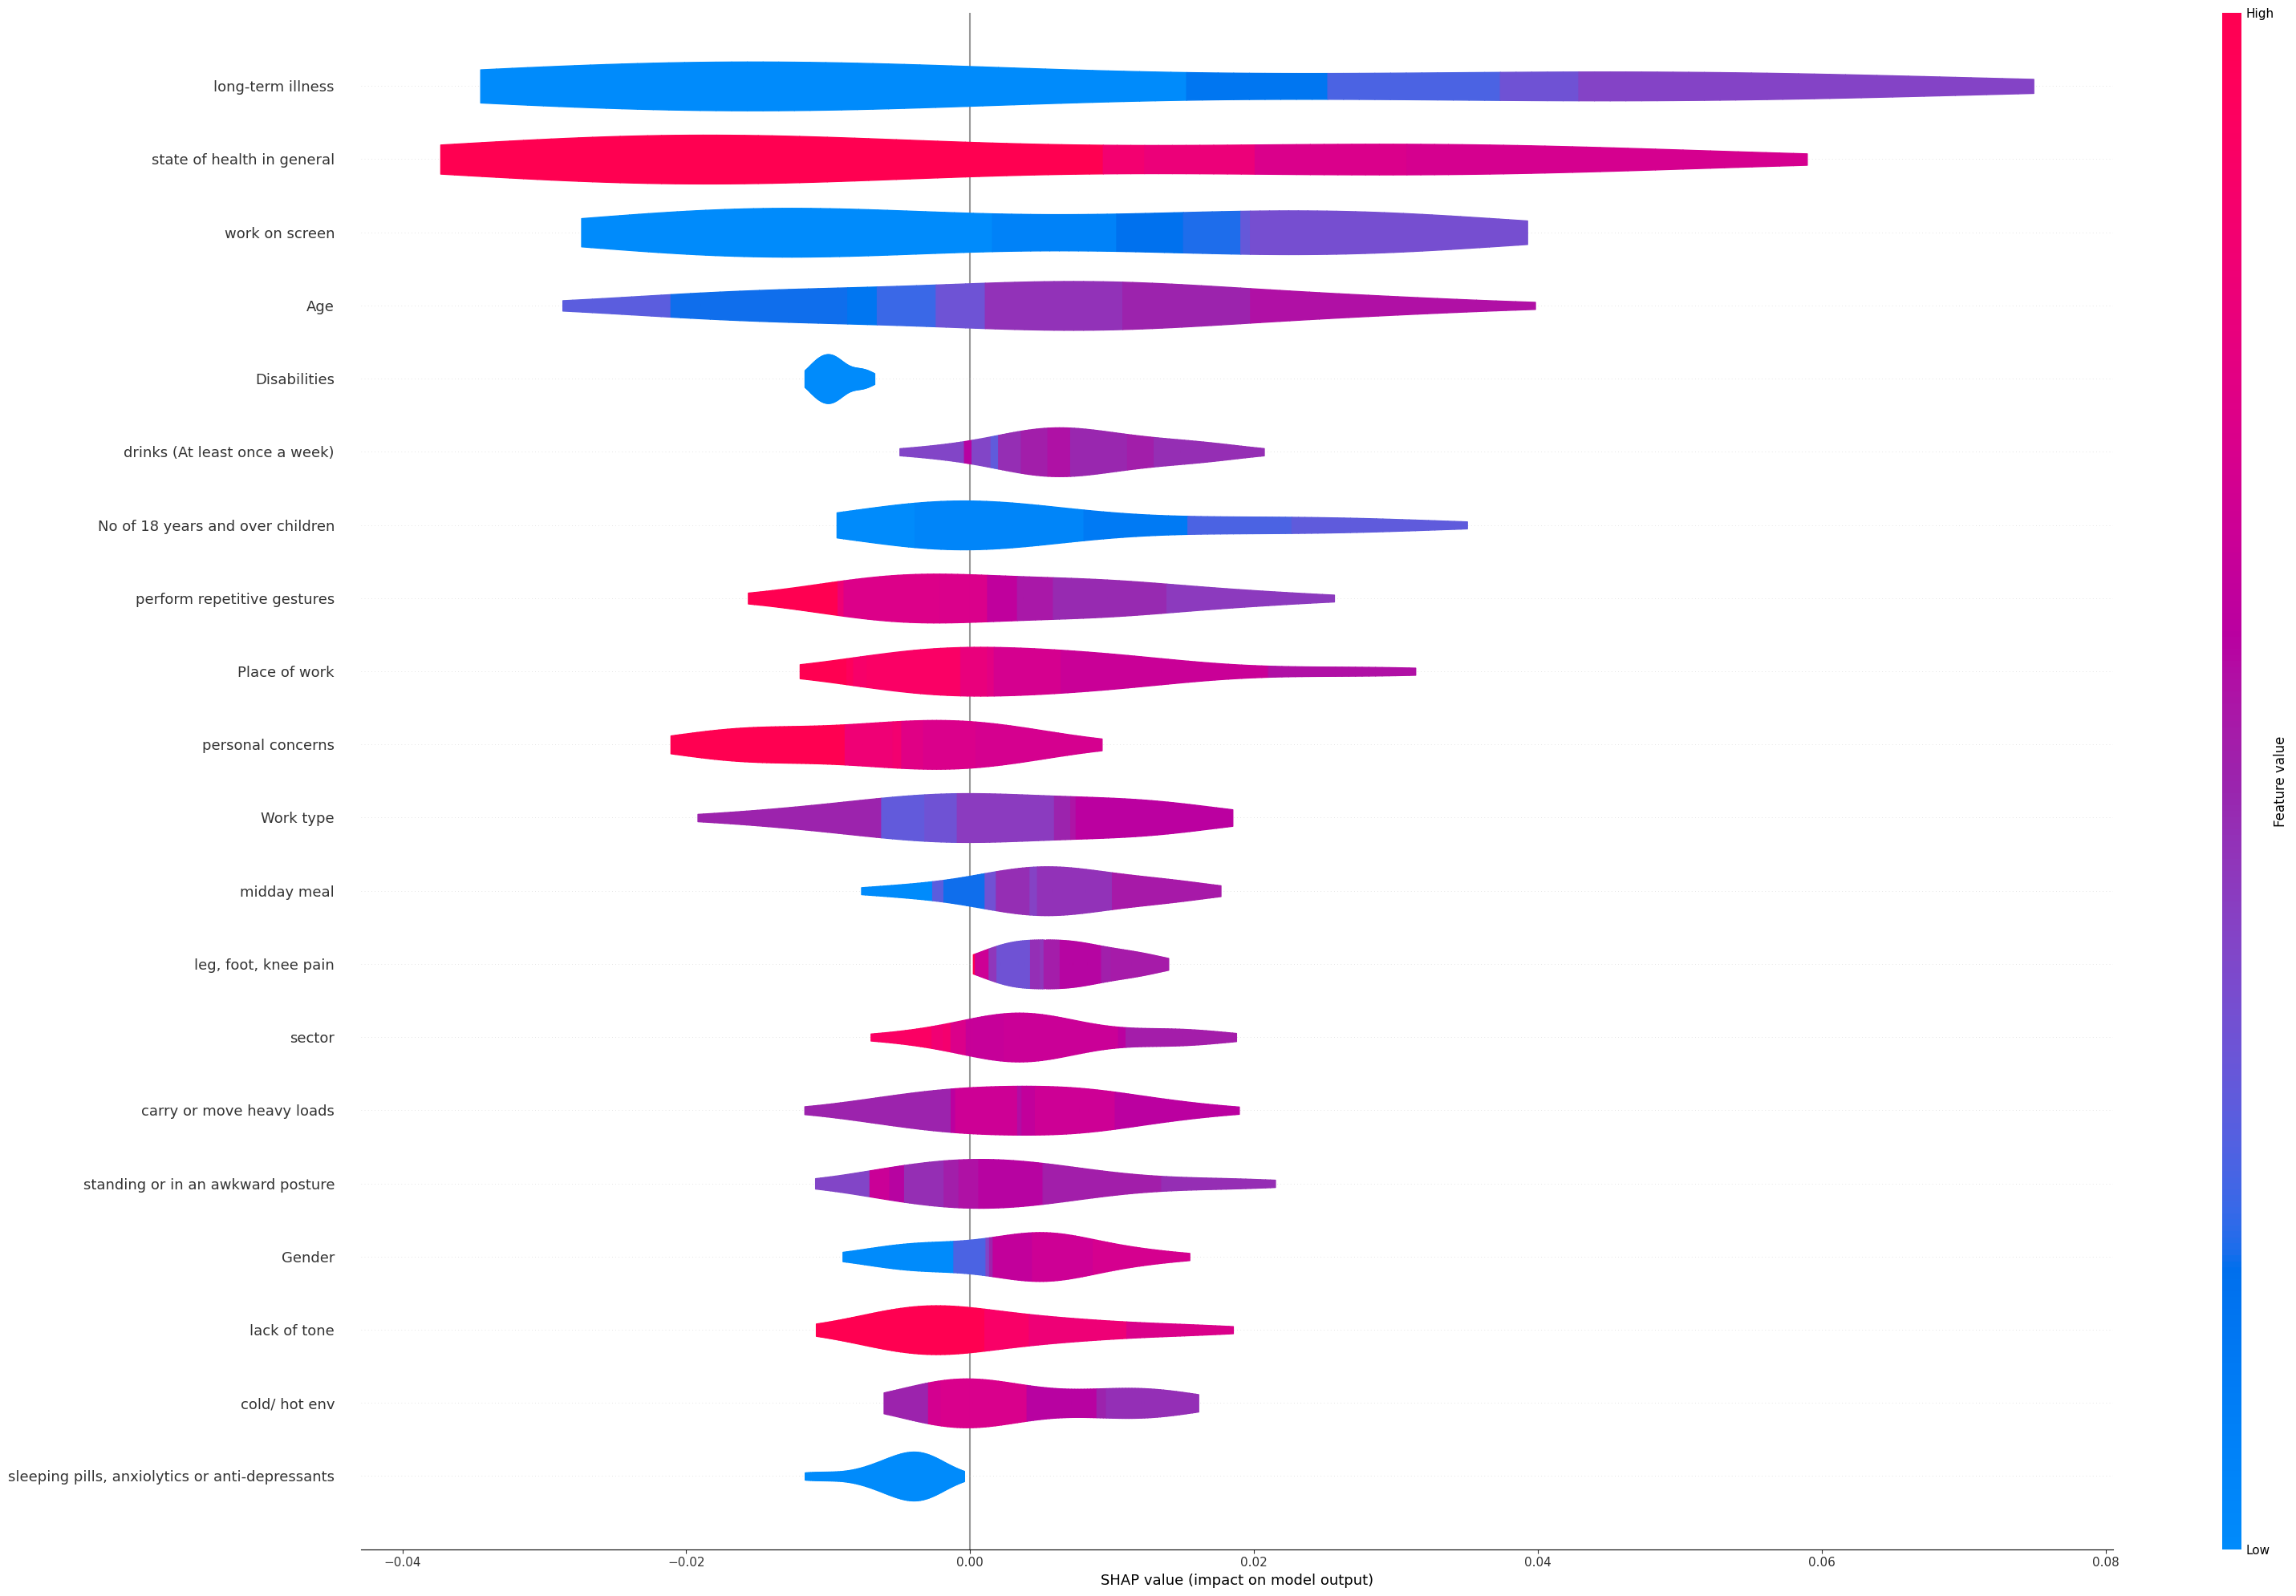

In [16]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_type="violin", plot_size=(32,20), show=False)
plt.savefig('outputs/02_23_shap/summary_plot_violin_for_10_samples.png', bbox_inches='tight')
plt.show()

### XGBoost
max_depth = 3

In [17]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({"eta": 1, "max_depth": 3, "base_score": 0, "lambda": 0}, Xd, 1)

print("Model error =", np.linalg.norm(y - model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 44.263035
0:[long-term illness<1] yes=1,no=2,missing=2,gain=56.21875,cover=8923
	1:[work on screen<1] yes=3,no=4,missing=4,gain=16.7539062,cover=5828
		3:[Disabilities<1] yes=7,no=8,missing=8,gain=10.2910156,cover=3164
			7:leaf=2.51386571,cover=2993
			8:leaf=2.76608181,cover=171
		4:[state of health in general<2] yes=9,no=10,missing=10,gain=6.78125,cover=2664
			9:leaf=2.70153856,cover=975
			10:leaf=2.59680295,cover=1689
	2:[Disabilities<1] yes=5,no=6,missing=6,gain=11.0175781,cover=3095
		5:[personal concerns<1] yes=11,no=12,missing=12,gain=7.26757812,cover=2369
			11:leaf=2.81930184,cover=487
			12:leaf=2.68225288,cover=1882
		6:[carry or move heavy loads<1] yes=13,no=14,missing=14,gain=1.69335938,cover=726
			13:leaf=2.92376685,cover=223
			14:leaf=2.8190856,cover=503



In [18]:
# Calculate model accuracy and F1 score

y_pred = model.predict(Xd) > 0.5
print(f"F1 Score {f1_score(y, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y, y_pred)}")

F1 Score 0.0
Accuracy 0.0


In [19]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)
shap_values = explanation.values

# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

7.1525574e-07

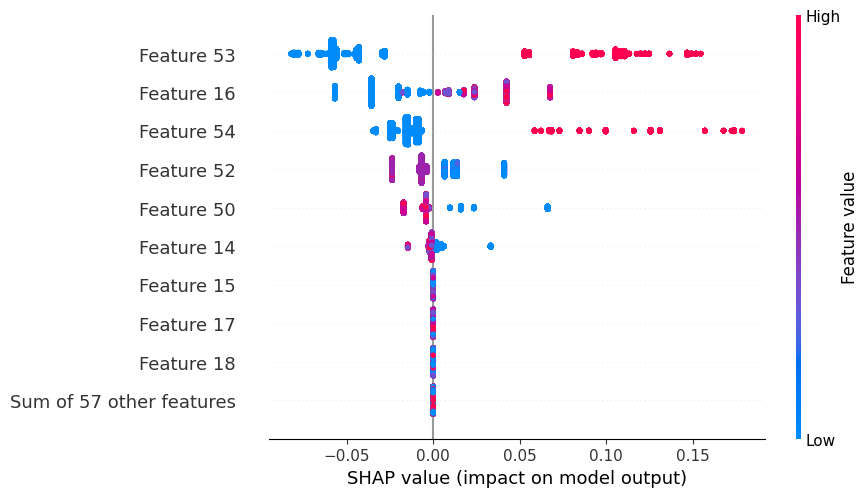

In [20]:
"""
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.
The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution
of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).
"""
shap.plots.beeswarm(explanation, show=False)
plt.savefig('outputs/02_23_shap/shap_beeswarm_plot_xg_4.png', bbox_inches='tight')
plt.show()

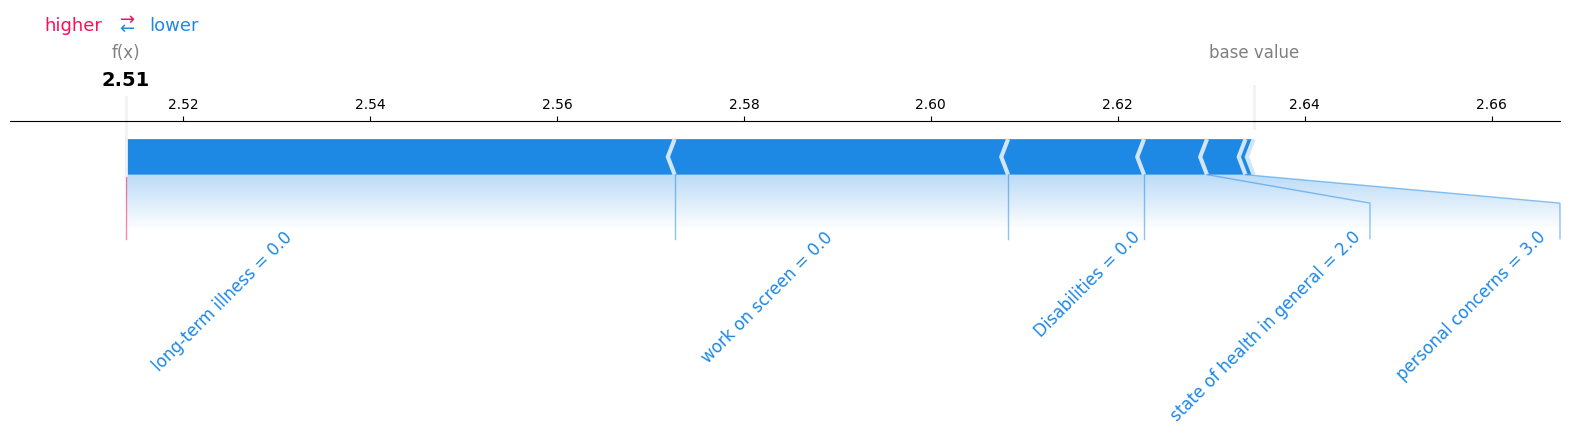

In [21]:
shap.force_plot(explanation.base_values[0], shap_values[0,:], X.iloc[0,:], text_rotation=45, matplotlib=True, show= False) # shows the shap values for the second prediction
plt.savefig('outputs/02_23_shap/shap_force_plot_xg_4.png', bbox_inches='tight')
plt.show()

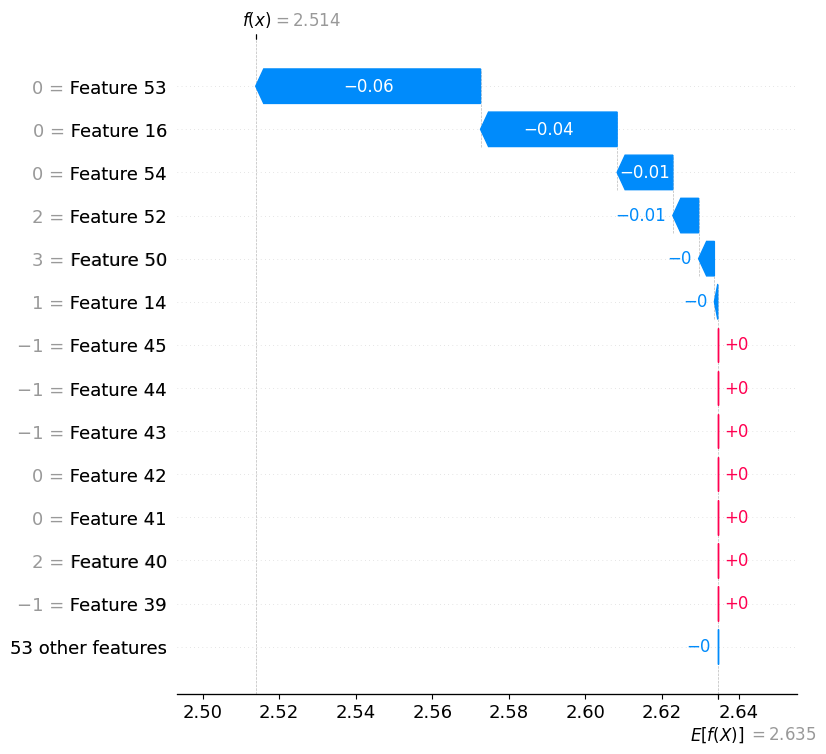

In [22]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(explanation[0,:], max_display=14, show=False)
plt.figsize=(32,18)
plt.savefig('outputs/02_23_shap/shap_waterfall_plot_xg_4.png', bbox_inches='tight')
plt.show()

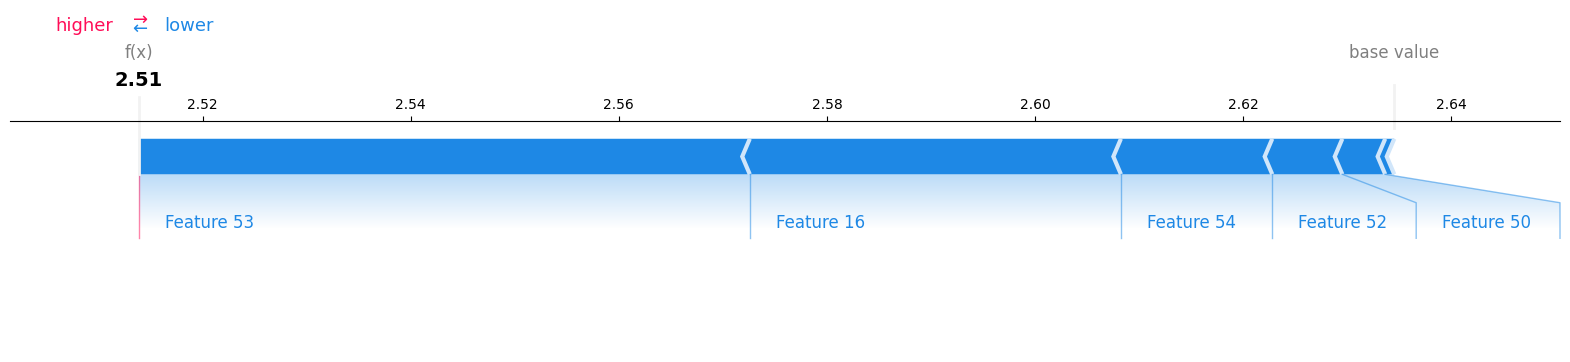

In [23]:
shap.plots.force(explainer.expected_value, shap_values[0, ...], show= False, matplotlib=True) # shap_values[0, ...] is the SHAP values for the first instance in the dataset ... is a numpy slice that means "all of the other axes"
plt.savefig('outputs/02_23_shap/shap_force_plot_xg_4_2.png', bbox_inches='tight')
plt.show()

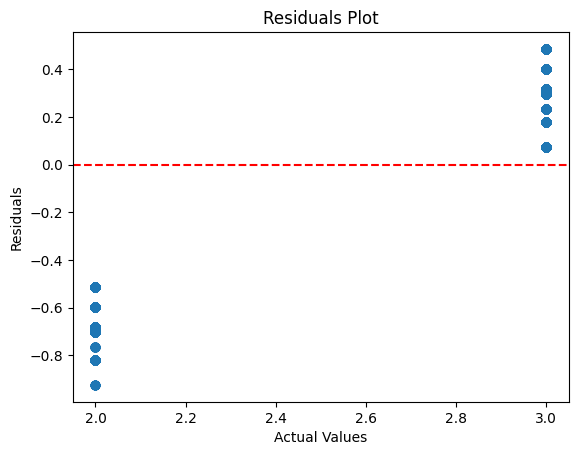

In [24]:
residuals = y - model.predict(Xd)
plt.scatter(y, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# save the plot
plt.savefig('outputs/02_23_shap/residuals_plot.png', bbox_inches='tight')
plt.show()